In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from statistics import mode

DATA_PATH = '/home/youngmin/Dataset/cifar-10-batches-py/'

### 1. Data Exploration

In [2]:
def load_data(file_name):
    with open(DATA_PATH + file_name, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
        
    return dict

In [3]:
batches_meta = load_data('batches.meta')
batches_meta

{'num_cases_per_batch': 10000,
 'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_vis': 3072}

In [4]:
batch = load_data('data_batch_1')
print(type(batch))

<class 'dict'>


In [5]:
for key, value in batch.items():
    print(f'type of data for {key}={type(value)}, len={len(value)}')

type of data for batch_label=<class 'str'>, len=21
type of data for labels=<class 'list'>, len=10000
type of data for data=<class 'numpy.ndarray'>, len=10000
type of data for filenames=<class 'list'>, len=10000


In [6]:
print(batch['batch_label'])

training batch 1 of 5


In [7]:
# print unique labels and data type
print(np.unique(batch['labels']))
print(type(batch['labels'][0]))

[0 1 2 3 4 5 6 7 8 9]
<class 'int'>


In [8]:
print(batch['data'].shape)
print(type(batch['data'][0][0]))
print('min value in data =', np.min(batch['data']))
print('max value in data =', np.max(batch['data']))

(10000, 3072)
<class 'numpy.uint8'>
min value in data = 0
max value in data = 255


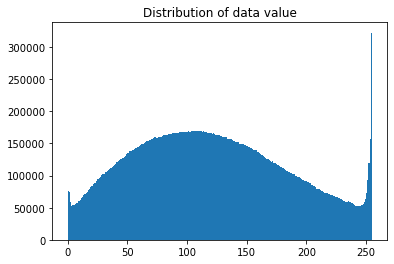

In [9]:
plt.figure()
plt.hist(batch['data'].reshape(-1), bins=256)
plt.title('Distribution of data value')
plt.show()

In [10]:
# check sample images and labels
def show_sample(batch, idx):
    # show image with a label
    sample_image = np.swapaxes(batch['data'][idx].reshape(32, 32, 3, order='F'), 0, 1)
    plt.figure()
    plt.imshow(sample_image)
    plt.title(batch['labels'][idx])
    plt.show()

    # show arrays
    with np.printoptions(threshold=np.inf):
        print('Red')
        print(sample_image[:, :, 0])
        print('Green')
        print(sample_image[:, :, 1])
        print('Blue')
        print(sample_image[:, :, 2])

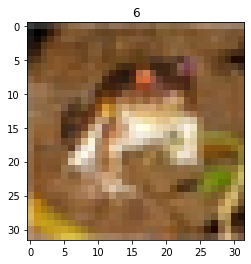

Red
[[ 59  43  50  68  98 119 139 145 149 149 131 125 142 144 137 129 137 134
  124 139 139 133 136 139 152 163 168 159 158 158 152 148]
 [ 16   0  18  51  88 120 128 127 126 116 106 101 105 113 109 112 119 109
  105 125 127 122 131 124 121 131 132 133 133 123 119 122]
 [ 25  16  49  83 110 129 130 121 113 112 112 106 105 128 124 130 127 122
  115 120 130 131 139 127 126 127 130 142 130 118 120 109]
 [ 33  38  87 106 115 117 114 105 107 121 125 109 113 146 133 127 118 117
  127 122 132 137 136 131 124 130 132 135 130 125 121  94]
 [ 50  59 102 127 124 121 120 114 107 125 129 106 108 124 121 108  98 110
  117 120 134 140 131 141 135 127 121 119 103  87  75  67]
 [ 71  84 110 129 136 131 129 119 108 122 123 105 107 111 108  98  94  97
   83  88 102  97  88 118 140 136 120 107  88  67  35  32]
 [ 97 111 123 130 136 132 122 121 127 138 124 120 107  80  68  74 101 105
   65  58  63  78 136 122 139 151 129 108  95  96  89  66]
 [115 119 130 140 133 127 138 137 131 133 134 108  72  51  41  72

In [11]:
show_sample(batch, 0)

### 2. Load Data

In [13]:
# data file tuple
data_list_training = ('data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5')
data_test = 'test_batch'

In [14]:
# load and check training data
Xtr = []
Ytr = []

for batch_name in data_list_training:
    batch = load_data(batch_name)
    Xtr.append(batch['data'])
    Ytr.append(batch['labels'])
    
Xtr = np.concatenate(Xtr)
Ytr = np.concatenate(Ytr)

In [15]:
print(Xtr.shape)
print(Ytr.shape)

(50000, 3072)
(50000,)


In [16]:
labels, counts = np.unique(Ytr, return_counts=True)
print({label:count for label, count in zip(labels, counts)})

{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


In [17]:
# load and check test data
batch = load_data(data_test)
Xte = batch['data']
Yte = np.array(batch['labels'])
print(Xte.shape)
print(Yte.shape)


(10000, 3072)
(10000,)


### 3. Linear Classifier

<img src="cs231n_slide_001.png" width="600"></img>

### Our dimensions
* a mini-batch of images, x: (batch_size, n_dim) = (batch_size, 3072)
* weight matrix, W: (n_dim, n_class) = (3072, 10)
* bias, b: (n_class) = (10)
* output: np.dot(x, W) + b, shape = (batch_size, 3072) • (3072, 10) + (10) = (batch_size, 10)

In [18]:
# linear classifer class
class LinearClassifier(object):

    # initialize parameters
    def __init__(self, n_dim, n_class):
        # n_dim = number of pixels in image (3072 in CIFAR-10 image)
        # n_class = number of classes to classify (10 in CIFAR-10)
        self.W = np.random.randn(n_dim, n_class)  # initial random weight: W.shape = (10, 3072)
        self.b = np.zeros(n_class) # initial zero bias: b.shape = (10)

    # forward-pass: giving softmax scores for each class
    def forward(self, x): # x is a mini-batch of images: x.shape = (batch_size, n_dim)
        return np.dot(x, self.W) + self.b


In [19]:
# make an instance of linear classifier
n_dim = Xtr.shape[1]
n_class = 10

lc = LinearClassifier(n_dim, n_class)

print('shape of W =', lc.W.shape)
print('shape of b =', lc.b.shape)

shape of W = (3072, 10)
shape of b = (10,)


In [20]:
# normalize data (run just once!)
Xtr = (Xtr - 127.5) / 255
Xte = (Xte - 127.5) / 255

In [21]:
# check normalized data
print('Training set')
print('global mean = %.5f' % np.mean(Xtr))
print('global std  = %.5f' % np.std(Xtr))
print('global max = %.5f' % np.max(Xtr))
print('global min = %.5f' % np.min(Xtr))

print()
print('Test set')
print('global mean = %.5f' % np.mean(Xte))
print('global std  = %.5f' % np.std(Xte))
print('global max = %.5f' % np.max(Xte))
print('global min = %.5f' % np.min(Xte))

Training set
global mean = -0.02664
global std  = 0.25157
global max = 0.50000
global min = -0.50000

Test set
global mean = -0.02342
global std  = 0.25122
global max = 0.50000
global min = -0.50000


In [22]:
# sample mini-batch
mini_batch = Xtr[:4, :] # the first 4 images from training set
print('shape of mini batch =', mini_batch.shape)

shape of mini batch = (4, 3072)


In [23]:
# output
output = lc.forward(mini_batch)
print('shape of output =', output.shape) # each row assigns 10 numbers 
print(output)

# output - np.max(output, axis=1)[:, np.newaxis]

shape of output = (4, 10)
[[  6.19753789 -14.62859206 -11.00103395  11.23478537 -18.97158335
    7.78850014  14.76150544   2.79917452  15.21169334  -6.01630106]
 [ 26.94257572   2.00412335  11.49018554   0.77082373  -1.88651534
    1.98858418  -3.80694921  -2.61440709  15.75523734  -9.33087724]
 [ 14.42723586  -7.9025127    9.41526175  17.135364     7.29097973
  -15.48421154  -1.54725159   8.39991433 -21.91234378  -2.39185283]
 [  1.65946135 -10.79406384   8.23771669  12.1803299   -5.3701786
   26.45854312  -0.31081592  -6.72476082   4.31732147  -0.05013305]]


In [24]:
output.sum(axis=1)

array([ 7.37568628, 41.31278097,  7.43058323, 29.60342032])

In [25]:
# softmax function (raw ver)
def softmax(y): # input y is output of the model y = xW + b
    denominator = np.sum(np.exp(y), axis=1)[:, np.newaxis]
    return np.exp(y) / denominator

In [26]:
# too big or small numbers may cause numerical unstability
softmax(output)

array([[7.34321283e-05, 6.62541060e-14, 2.49253500e-12, 1.13118828e-02,
        8.61143728e-16, 3.60439386e-04, 3.84742326e-01, 2.45468434e-06,
        6.03509465e-01, 3.64320201e-10],
       [9.99985957e-01, 1.47693591e-11, 1.94583547e-07, 4.30275315e-12,
        3.01771858e-13, 1.45416294e-11, 4.42226645e-14, 1.45733491e-13,
        1.38482399e-05, 1.76454785e-16],
       [6.24569254e-02, 1.25283541e-11, 4.15822420e-04, 9.36926901e-01,
        4.96985759e-05, 6.38563438e-15, 7.21022552e-09, 1.50642710e-04,
        1.03157709e-17, 3.09844071e-09],
       [1.69783449e-11, 6.62823783e-17, 1.22122405e-08, 6.29579399e-07,
        1.50300876e-14, 9.99999358e-01, 2.36709019e-12, 3.87859050e-15,
        2.42208475e-10, 3.07204757e-12]])

In [27]:
softmax(output).sum(axis=1)

array([1., 1., 1., 1.])

In [28]:
# softmax function (stable ver)
def softmax(y): # input y is output of the model y = xW + b
    y = y - np.max(y, axis=1)[:, np.newaxis] # maximum output would be 0, np.exp(max) = 1
    denominator = np.sum(np.exp(y), axis=1)[:, np.newaxis]
    return np.exp(y) / denominator

In [29]:
softmax(output)

array([[7.34321283e-05, 6.62541060e-14, 2.49253500e-12, 1.13118828e-02,
        8.61143728e-16, 3.60439386e-04, 3.84742326e-01, 2.45468434e-06,
        6.03509465e-01, 3.64320201e-10],
       [9.99985957e-01, 1.47693591e-11, 1.94583547e-07, 4.30275315e-12,
        3.01771858e-13, 1.45416294e-11, 4.42226645e-14, 1.45733491e-13,
        1.38482399e-05, 1.76454785e-16],
       [6.24569254e-02, 1.25283541e-11, 4.15822420e-04, 9.36926901e-01,
        4.96985759e-05, 6.38563438e-15, 7.21022552e-09, 1.50642710e-04,
        1.03157709e-17, 3.09844071e-09],
       [1.69783449e-11, 6.62823783e-17, 1.22122405e-08, 6.29579399e-07,
        1.50300876e-14, 9.99999358e-01, 2.36709019e-12, 3.87859050e-15,
        2.42208475e-10, 3.07204757e-12]])

In [30]:
# linear classifer class with softmax output
class LinearClassifier(object):

    # initialize parameters
    def __init__(self, n_dim, n_class):
        # n_dim = number of pixels in image (3072 in CIFAR-10 image)
        # n_class = number of classes to classify (10 in CIFAR-10)
        self.W = np.random.randn(n_dim, n_class)  # initial random weight: W.shape = (10, 3072)
        self.b = np.zeros(n_class) # initial zero bias: b.shape = (10)

    # forward-pass: giving softmax scores for each class
    def forward(self, x): # x is a mini-batch of images: x.shape = (batch_size, n_dim)
        y = np.dot(x, self.W) + self.b
        return softmax(y)


In [31]:
# make an instance of linear classifier
n_dim = Xtr.shape[1]
n_class = 10

lc = LinearClassifier(n_dim, n_class)

print('shape of W =', lc.W.shape)
print('shape of b =', lc.b.shape)

shape of W = (3072, 10)
shape of b = (10,)


In [32]:
# output
output = lc.forward(mini_batch)
print('shape of output =', output.shape) # each row assigns 10 numbers 
print(output)

shape of output = (4, 10)
[[2.13230912e-11 9.15327746e-02 1.65475448e-03 1.64295128e-10
  1.53520015e-11 4.48767675e-15 9.06805907e-01 4.19364151e-19
  8.67494023e-07 5.69596122e-06]
 [8.36758999e-09 1.07390425e-02 9.89015526e-01 3.12059184e-13
  9.49224146e-12 3.53558554e-07 2.25365333e-04 1.96642461e-05
  4.00822305e-08 2.08274052e-13]
 [8.09147962e-23 5.15929474e-08 4.52641549e-04 9.99547307e-01
  9.14211527e-19 7.94554433e-29 3.15425697e-37 1.85335878e-33
  3.99342438e-26 1.66260300e-10]
 [2.22042315e-08 9.49101465e-08 9.85293522e-01 2.71384265e-07
  3.80657265e-14 3.02058740e-16 1.47060694e-02 1.77777943e-20
  1.93437763e-08 8.95743497e-10]]


In [33]:
output.sum(axis=1)

array([1., 1., 1., 1.])

In [34]:
Ytr[:10]

array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

In [41]:
# one-hot encoder
def onehot(y, n_class):
    vectors = np.zeros((len(y), n_class))
    for i, label in enumerate(y):
        vectors[i, label] = 1
    return vectors

In [42]:
onehot(Ytr[:10], n_class)

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [43]:
# cross-entropy loss
def loss(y_true, y_pred):
    return np.sum(-y_true * np.log(y_pred), axis=1)
    

In [45]:
loss(onehot(Ytr[:4], n_class), output)

array([ 0.09782685, 29.19992162, 22.51746648, 30.89946208])

In [46]:
# true labels
Ytr[:4]

array([6, 9, 9, 4])

In [49]:
# model prediction
np.argmax(output, axis=1)

array([6, 2, 3, 2])

In [50]:
# cross-entropy loss to give a single number
def loss(y_true, y_pred):
    return np.mean(np.sum(-y_true * np.log(y_pred), axis=1))
    

In [51]:
loss(onehot(Ytr[:4], n_class), output) # mean of 4 losses

20.678669259870297

In [56]:
# calculate loss for the entire test set
y_pred = lc.forward(Xte)
y_true = onehot(Yte, n_class)
test_loss = loss(y_true, y_pred)
print('Test loss = %.5f' % test_loss)

Test loss = 21.45921
